In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,Conv2D
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 255
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle="True",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [13]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [71]:
len(dataset)

68

In [72]:
68*32

2176

In [10]:
2176-2152

24

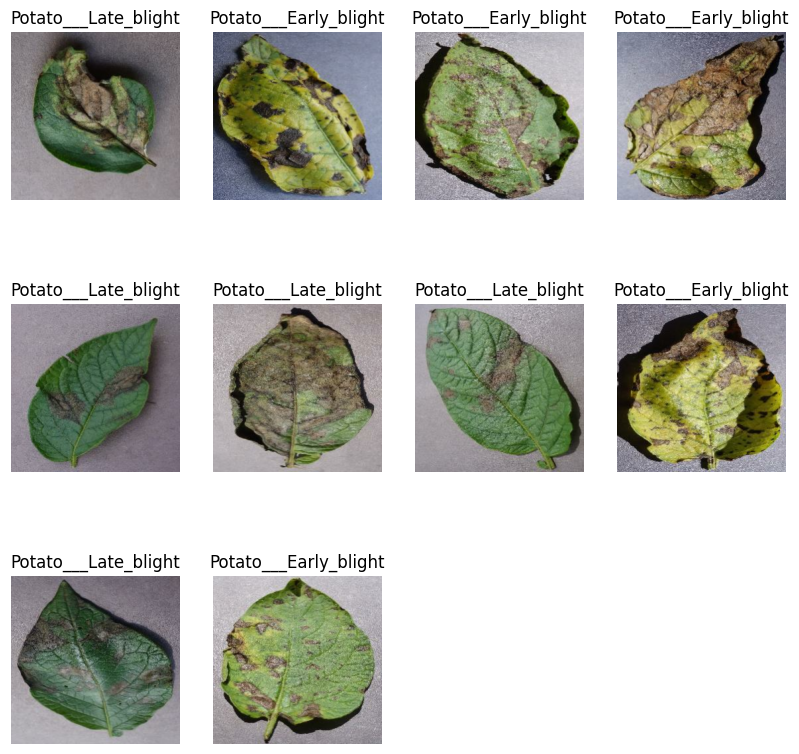

In [49]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [11]:
train_s = 0.8
len(dataset)*train_s

54.400000000000006

In [12]:
train_d = dataset.take(54)
len(train_d)

54

In [17]:
test_d = dataset.skip(54)
len(test_d)

14

In [18]:
val_d = 0.1
len(dataset)*val_d

6.800000000000001

In [20]:
val_d = test_d.take(6)
len(val_d)

6

In [22]:
test_d = test_d.skip(6)
len(test_d)

14

In [5]:
def dataset_partiton(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = dataset_partiton(dataset)

In [75]:
len(train_ds)

54

In [76]:
len(test_ds)

8

In [77]:
len(val_ds)

6

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [79]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [80]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [81]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,3)
classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = INPUT_SHAPE),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(classes, activation = 'softmax')
])

In [35]:
model.build(input_shape=INPUT_SHAPE)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 126, 126, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [37]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
H = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

In [108]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 270ms/step - loss: 0.0159 - accuracy: 0.9922


[0.015873311087489128, 0.9921875]

In [127]:
import joblib

In [129]:
model = "model"
filename = "model.pkl"
joblib.dump(model, filename)

['model.pkl']

In [ ]:
model.save("E:\Deep Learning\Projects\Potato\Potato_disease\Model_original")

In [21]:
model = tf.keras.models.load_model("E:\Deep Learning\Projects\Potato\Potato_disease\Model_original")

In [22]:
def predict(model, img):
    img = tf.image.resize(img, (256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


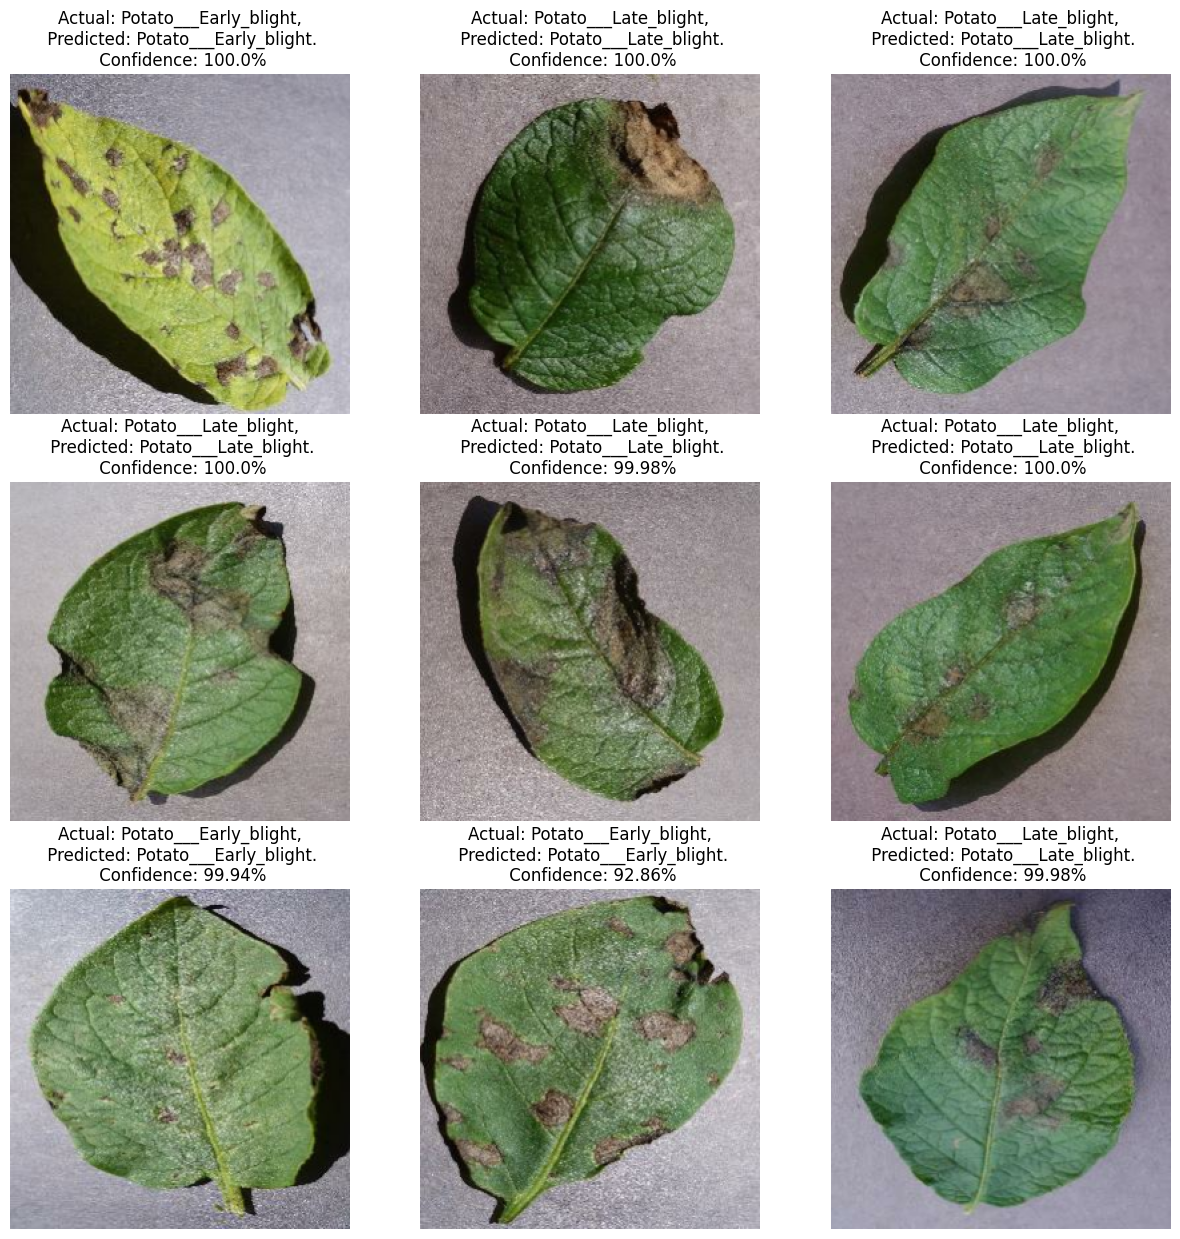

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")